# Information Processing Capacity Analysis
In this notebook, the analysis leading to the plots in the [Memory vs Nonlinearity paper](https://www.mdpi.com/2313-7673/9/12/755) are presented.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import pandas as pd
from utils import createNARMA10, createNARMA30, region_specific_IPC, IPC_overlap

# Some helper functions

def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

def cap2mat(capacities,maxdel=1000,maxdeg=10,maxwin=10):
    vec = np.zeros((maxdel,maxwin,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        win=capacities[idx]['window']
        if (delay<=maxdel) and (degree<=maxdeg) and (win<=maxwin):
            vec[delay-1, win-1, degree-1]+=capacities[idx]['score']
    return vec

# Task capacity
Load Taks capacity for NARMA-30. New task caps can be computed from [computeTaskCaps.py](../ipc-scripts/computeTaskCaps.py).

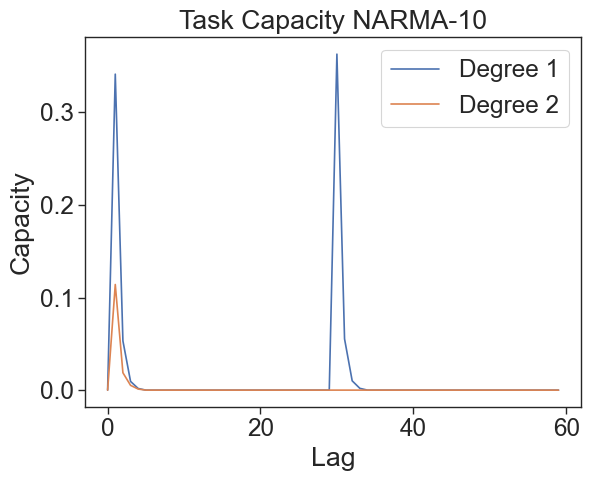

In [16]:
caps_path = "../results/ipc-results/narma_30_task_caps_2025-02-27.p"
with open(caps_path, "rb") as f:
    tc_dict = pkl.load(f)
task_caps = tc_dict['taskCap']
maxdel = tc_dict['maxdel']
maxdeg = tc_dict['maxdeg']
V10 = cap2vec(task_caps, maxdel = maxdel, maxdeg = maxdeg)
plt.plot(V10)
plt.ylabel('Capacity')
plt.xlabel('Lag')
plt.title('Task Capacity NARMA-10')
plt.legend(['Degree ' + str(i + 1) for i in range(maxdeg)])

# Performance Estimate using task-overlap metric based on region-specific IPC

Task IPC is first computed, then the non-zero task-capacities define a specific task-relevant IPC region. The region-specific IPC is then computed for random networks with a gridsearch over spectral radius and leak rate. Here we load existing gridsearch results. Generating new results can be done with [randomNetOverlap.py](../ipc-scripts/randomNetOverlap.py).


In [3]:
with open('../results/ipc-results/final_results_unopt_6.p', 'rb') as f:
    gridsearch_results = pkl.load(f)

In [17]:
results_df = pd.DataFrame(gridsearch_results)
results_df['sr'] = results_df['sr'].round(2)
results_df['leak'] = results_df['leak'].round(2)
df_bl = results_df[results_df['net_type'] == 'ESN']
df_ddn = results_df[results_df['net_type'] == 'DDN']
df_ddn.head()

,sr,leak,task_p,regional_cap,overlap,net_type
1,0.5,0.30,0.622819,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.698692,DDN
3,0.5,0.30,0.625894,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.618493,DDN
5,0.5,0.30,0.662610,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.570308,DDN
7,0.5,0.36,0.630535,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.619869,DDN
9,0.5,0.36,0.610623,"[{'degree': 1, 'variables': 1, 'powerlist': [1...",0.786051,DDN


<AxesSubplot: title={'center': 'DDN NARMA-30 NRMSE'}, xlabel='leak', ylabel='sr'>

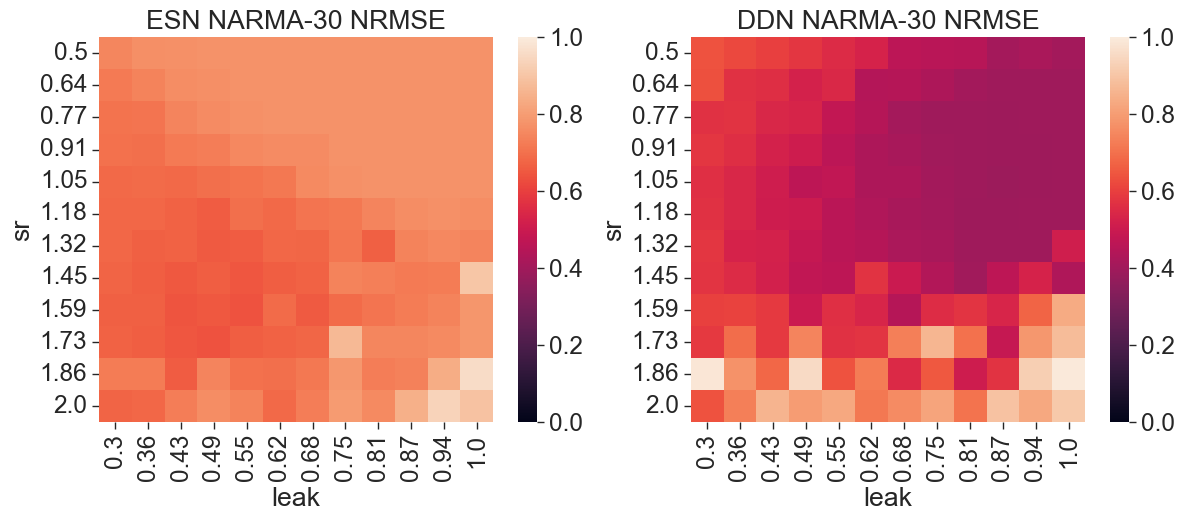

In [18]:
metr = 'task_p'
df_bl_hm = df_bl.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
df_ddn_hm = df_ddn.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')

fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
ax[0].set_title('ESN NARMA-30 NRMSE')
sns.heatmap(df_bl_hm, ax=ax[0], vmin=0, vmax=1)
ax[1].set_title('DDN NARMA-30 NRMSE')
sns.heatmap(df_ddn_hm, ax=ax[1], vmin=0, vmax=1)
# plt.savefig("figs/gridsearch_N30.svg")


<AxesSubplot: title={'center': 'DDN-NARMA-30 overlap score'}, xlabel='leak', ylabel='sr'>

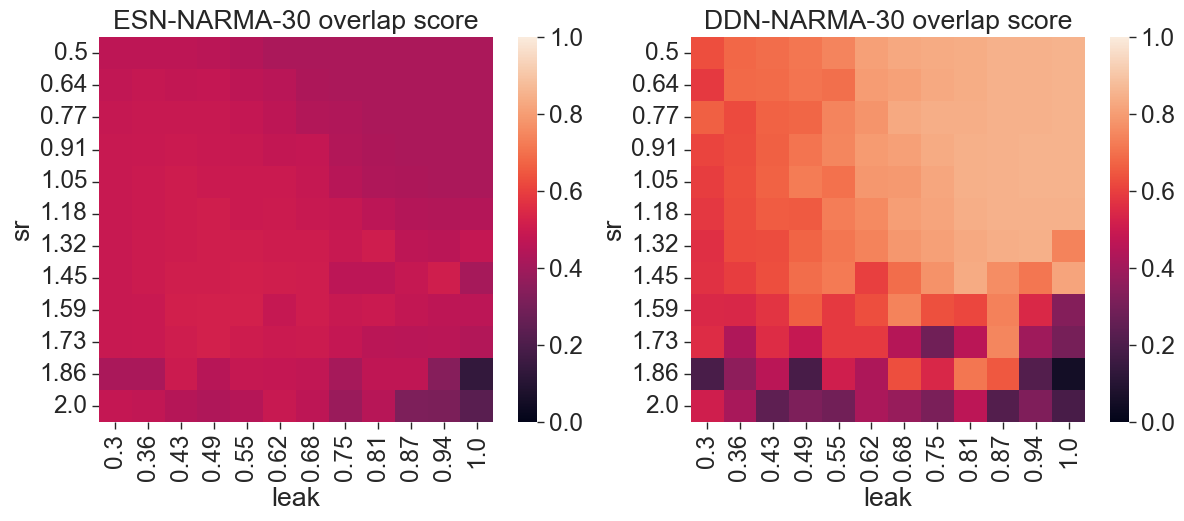

In [19]:
metr = 'overlap'
df_bl_hm = df_bl.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
df_ddn_hm = df_ddn.pivot_table(index="sr", columns="leak", values=metr, aggfunc='mean')
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
ax[0].set_title('ESN-NARMA-30 overlap score')
sns.heatmap(df_bl_hm, ax=ax[0], vmin=0, vmax=1)
ax[1].set_title('DDN-NARMA-30 overlap score')
sns.heatmap(df_ddn_hm, ax=ax[1], vmin=0, vmax=1)
# plt.savefig("figs/gridsearch_overlap_N30.svg")


(0.0, 0.9)

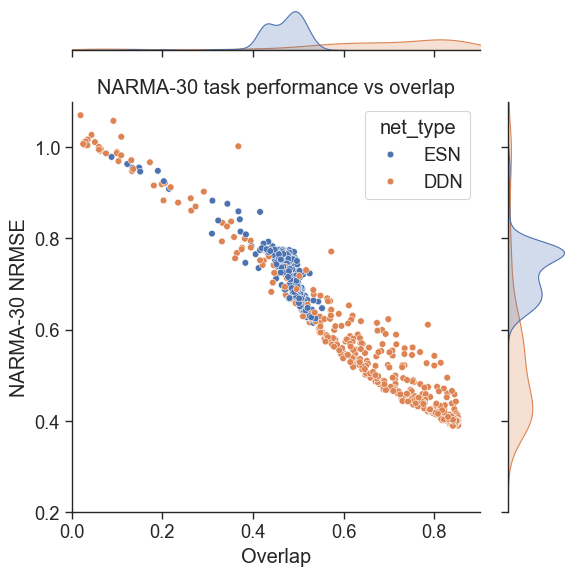

In [20]:
sns.set_theme(style="ticks", font_scale=1.5, palette='deep', context='paper')
sns.jointplot(results_df, x="overlap", y="task_p", hue='net_type')
plt.title('NARMA-30 task performance vs overlap')
plt.xlabel('Overlap')
plt.ylabel('NARMA-30 NRMSE')
plt.ylim(0.2, 1.1)
plt.tight_layout()
plt.xlim(0, 0.9)

# plt.savefig('figs/overlap_scatter.svg')

# Task profile overlap of optimized networks
In the cells above, we looked at unoptimized networks in a minimal 2-parameter sweep. Now we look at optimized (evolved) networks. First, we load the IPC data of a previous IPC run. To compute new IPC data, run [evolvedNetOverlap.py](../ipc-scripts/evolvedNetOverlap.py).

In [26]:
with open('../results/ipc-results/narma_30_evolved_IPC_DDN2025-02-27.p', 'rb') as file:
    evo_ipc_dict_ddn = pkl.load(file)
    p_ipc_ddn = evo_ipc_dict_ddn['r_ipc']

with open('../results/ipc-results/narma_30_evolved_IPC_ESN2025-02-27.p', 'rb') as file:
    evo_ipc_dict_bl = pkl.load(file)
    p_ipc_bl = evo_ipc_dict_bl['r_ipc']
    task_allcaps_30 = evo_ipc_dict_bl['task_caps']

def write_opt_ipc(dict, gen, test_p, overlap):
    dict['gen'].append(gen)
    dict['test performance'].append(test_p)
    dict['overlap'].append(overlap)

p_ipc_dict_ddn = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}

p_ipc_dict_bl = {
    'gen' : [],
    'test performance': [],
    'overlap': []
}
for gen, res in enumerate(p_ipc_ddn):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = IPC_overlap(task_allcaps_30, r_ipc)
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_ddn, gen * 10, test_perf, overlap)

for gen, res in enumerate(p_ipc_bl):
    r_ipcs = res[1]
    test_perfs = res[0]
    for i in range(len(test_perfs)):
        r_ipc = r_ipcs[i]
        overlap = IPC_overlap(task_allcaps_30, r_ipc)
        test_perf = test_perfs[i]
        write_opt_ipc(p_ipc_dict_bl, gen * 10, test_perf, overlap)

## Scatterplot performance x overlap throughout evolution
A plot showing how task performance relates to task overlap, throughout the evolution for DDNs and ESNs.

Text(0.5, 1.0, 'NARMA-30 Optimized Networks: overlap and performance')

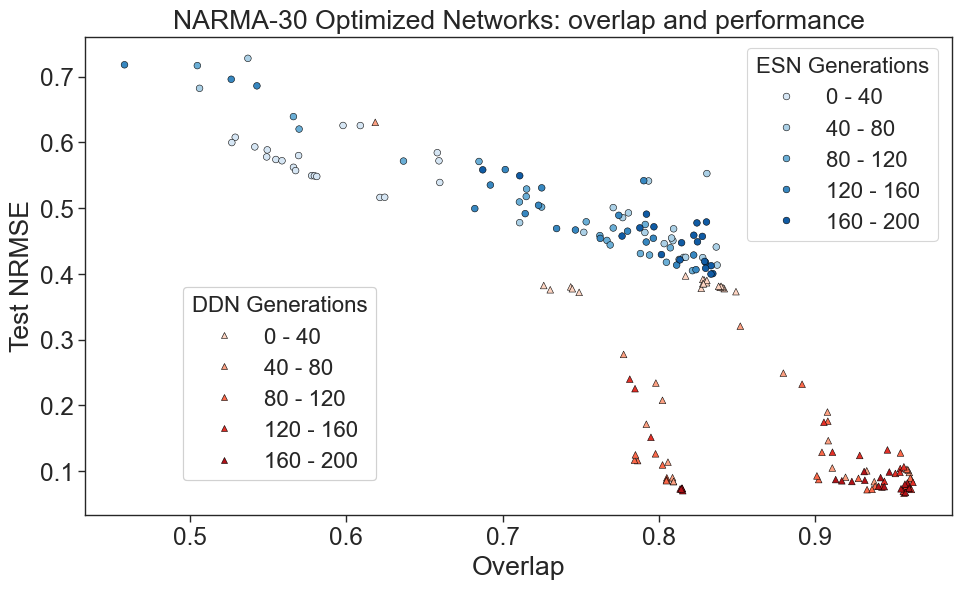

In [28]:
ddn_df = pd.DataFrame(p_ipc_dict_ddn)
bl_df = pd.DataFrame(p_ipc_dict_bl)

sns.set_theme(style="ticks", font_scale=2, palette='deep', context='paper')
fig, ax = plt.subplots(figsize=(10, 6))

n_bins = 5
n_steps = int(200/n_bins)
gen_bins = [str(i * n_steps) + ' - ' + str((i+1) * n_steps) for i in range(n_bins)]

bl_palette = sns.color_palette("Blues", len(gen_bins))
bl_df['Generation'] = pd.cut(bl_df['gen'], bins=n_bins, labels=gen_bins)

sns.scatterplot(bl_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=bl_palette, marker='o', edgecolor="black")

ddn_palette = sns.color_palette("Reds", len(gen_bins))
ddn_df['Generation'] = pd.cut(ddn_df['gen'], bins=5, labels=gen_bins)

sns.scatterplot(ddn_df, ax=ax, x='overlap', y='test performance', hue='Generation', palette=ddn_palette, marker='^', edgecolor="black")

handles_bl, labels_bl = ax.get_legend_handles_labels()
legend_bl = ax.legend(handles_bl[:len(gen_bins)], labels_bl[:len(gen_bins)], title="ESN Generations", loc='upper left', bbox_to_anchor=(0.75, 1), fontsize='small', title_fontsize='small')

handles_ddn, labels_ddn = ax.get_legend_handles_labels()
legend_ddn = ax.legend(handles_ddn[len(gen_bins):], labels_ddn[len(gen_bins):], title="DDN Generations", loc='upper left', bbox_to_anchor=(0.1, 0.5), fontsize='small', title_fontsize='small')
ax.add_artist(legend_bl)
ax.add_artist(legend_ddn)

plt.tight_layout()
plt.ylabel('Test NRMSE')
plt.xlabel('Overlap')
plt.title('NARMA-30 Optimized Networks: overlap and performance')
# plt.savefig('figs/optimized_scatter_overlap.svg')

# IPC of optimized networks: a closer look
Here we have look at how exactly IPC relates to task capacity, not just with the overlap metric but also by visualizing the capacity landscapes.

First, we process the task capacity into a vector per degree, containing the total capacity per lag for each degree, and a matrix per degree, containing the capacity for each lag and window size for each degree.

In [33]:
task_cap_path = "../results/ipc-results/narma_30_task_caps_2025-02-27.p"
with open(task_cap_path, 'rb') as f:
    task_cap_dict = pkl.load(f)
maxdel = 45 #task_cap_dict['maxdel']
maxdeg = task_cap_dict['maxdeg']
task_allcaps = task_cap_dict['taskCap']

V30 = cap2vec(task_allcaps, maxdel = maxdel, maxdeg = maxdeg)
M30 = cap2mat(task_allcaps, maxdel = maxdel, maxdeg = maxdeg, maxwin=31)

Now, we do the same for the best DDN and the best ESN. The full IPC for these networks were computed before, here we load the results. To compute the IPC again, run [evolvedNetIPC.py](../ipc-scripts/evolvedNetIPC.py).

In [34]:
optimized_ipc_ddn_path = "../results/ipc-results/best_narma_30_evolved_full_IPC_DDN2025-02-28.p"
optimized_ipc_bl_path = "../results/ipc-results/best_narma_30_evolved_full_IPC_ESN2025-02-28.p"

with open(optimized_ipc_ddn_path, 'rb') as f:
    ipc_best_ddn = pkl.load(f)
with open(optimized_ipc_bl_path, 'rb') as f:
    ipc_best_bl = pkl.load(f)

# Compute vectors and matrices
Vs_ddn = []
Vs_bl = []
Ms_ddn = []
Ms_bl = []

for dict in ipc_best_ddn:
    ipc = dict['ipc']
    maxdel = dict['maxdel']
    maxdeg = dict['maxdeg']
    maxwin = dict['maxwin']
    V = cap2vec(ipc, maxdel = maxdel, maxdeg = maxdeg)
    M = cap2mat(ipc, maxdel = maxdel, maxdeg = maxdeg, maxwin=maxwin)
    Vs_ddn.append(V)
    Ms_ddn.append(M)

for dict in ipc_best_bl:
    ipc = dict['ipc']
    maxdel = dict['maxdel']
    maxdeg = dict['maxdeg']
    maxwin = dict['maxwin']
    V = cap2vec(ipc, maxdel = maxdel, maxdeg = maxdeg)
    M = cap2mat(ipc, maxdel = maxdel, maxdeg = maxdeg, maxwin=maxwin)
    Vs_bl.append(V)
    Ms_bl.append(M)

## Plot capacity average over resamples
next to task capacity, as a function of lag. Notice no real visible improvement overlap between the IPC landscape and task cap landscape. At least not if we only consider lag.

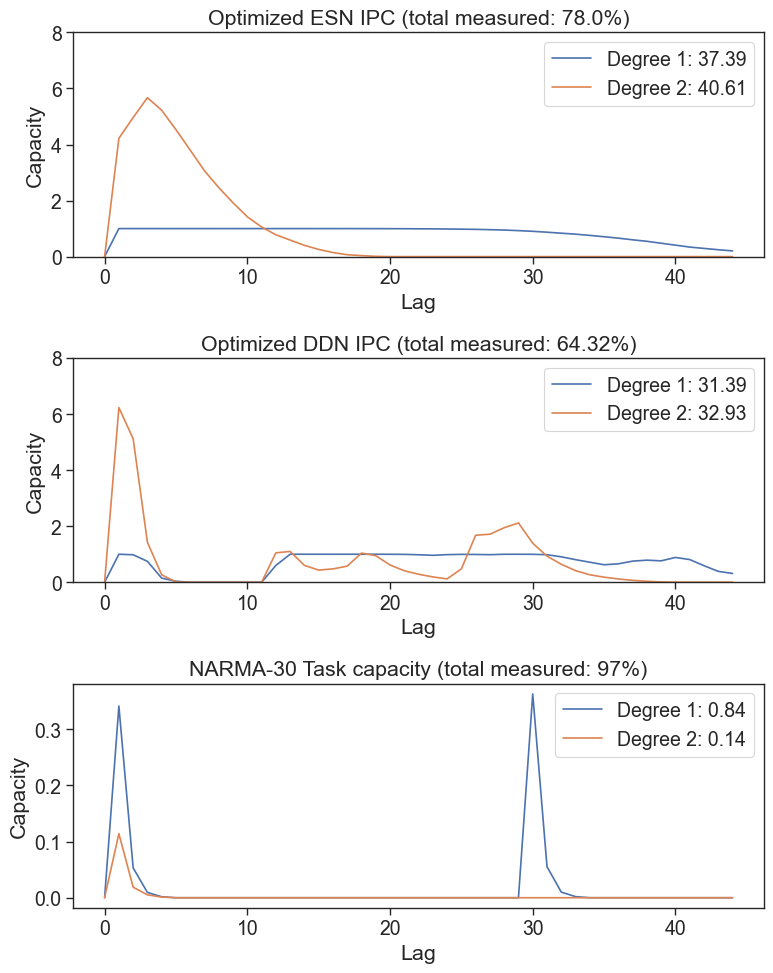

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(8,10))
sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')
V_arr = np.array(Vs_ddn)
av_Vs = np.mean(V_arr, axis=0)
total_Vs = np.sum(av_Vs, axis=0)
ax[1].set_title('Optimized DDN IPC (total measured: ' + str(np.round(np.sum(total_Vs), 2)) + '%)')
ax[1].plot(av_Vs)
ax[1].set_ylim(0, 8)
leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(total_Vs[i], 2)) for i in range(maxdeg)]
ax[1].legend(leg)
ax[1].set_ylabel('Capacity')
ax[1].set_xlabel('Lag')

V_arr = np.array(Vs_bl)
av_Vs = np.mean(V_arr, axis=0)
total_Vs = np.sum(av_Vs, axis=0)
ax[0].set_title('Optimized ESN IPC (total measured: ' + str(np.round(np.sum(total_Vs), 2)) + '%)')
ax[0].plot(av_Vs)
ax[0].set_ylim(0, 8)
ax[0].set_ylabel('Capacity')
ax[0].set_xlabel('Lag')

leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(total_Vs[i], 2)) for i in range(maxdeg)]
ax[0].legend(leg)

ax[2].plot(V30)
ax[2].set_title('NARMA-30 Task capacity (total measured: ' + str(int(np.sum(V30) * 100)) + '%)')
leg = ['Degree ' + str(i + 1) + ': ' + str(np.round(np.sum(V30[:, i]), 2)) for i in range(maxdeg)]
ax[2].legend(leg)
ax[2].set_ylabel('Capacity')
ax[2].set_xlabel('Lag')
plt.tight_layout()
# plt.legend(['degree 1', 'degree 2'])
# plt.ylabel('Capacity')
# plt.xlabel('Lag')
# plt.savefig('figs/best_IPC_opt.svg')

However, below we also consider maximum window size as an independent variable besides to lag. Now we see why DDNs obtain a better overlap score.

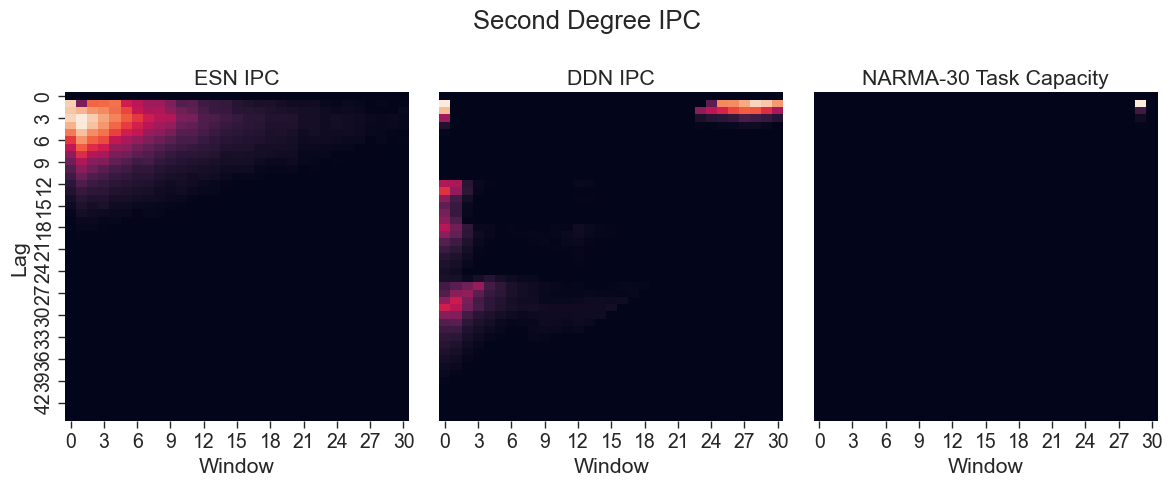

In [37]:
sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')

fig, ax = plt.subplots(1, 3, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1, 1]})

MIPC = np.array(Ms_ddn)
av_M_ddn = np.mean(MIPC, axis=0)

MIPC = np.array(Ms_bl)
av_M_bl = np.mean(MIPC, axis=0)

MIPC_30 = np.array(M30)

sns.heatmap(av_M_bl[:, :, 1], ax=ax[0], cbar=False)
sns.heatmap(av_M_ddn[:, :, 1], ax=ax[1], cbar=False, yticklabels=False)
sns.heatmap(MIPC_30[:, :, 1], ax=ax[2], cbar=False, yticklabels=False)
ax[0].set_ylabel('Lag')
ax[0].set_xlabel('Window')
ax[1].set_xlabel('Window')
ax[2].set_xlabel('Window')
ax[0].set_title('ESN IPC')
ax[1].set_title('DDN IPC')
ax[2].set_title('NARMA-30 Task Capacity')
fig.suptitle('Second Degree IPC')
plt.tight_layout()
# plt.savefig('figs/IPC_window.svg')